In [4]:
#run in python 3.10.7 on windows
import pandas as pd
import numpy as np

%matplotlib inline

niwaDf  = pd.read_csv('../data/niwa_cleaned/1971-2023-WeatherData.csv', parse_dates=['Date'])
niwaDf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18834 entries, 0 to 18833
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           18834 non-null  datetime64[ns]
 1   Wdir (Deg)     18831 non-null  float64       
 2   WSpd (m/s)     18831 non-null  float64       
 3   GustDir (Deg)  18484 non-null  float64       
 4   GustSpd (m/s)  18635 non-null  float64       
 5   Tdry (C)       18831 non-null  float64       
 6   Twet (C)       18792 non-null  float64       
 7   RH (%)         18792 non-null  float64       
 8   Tmax (C)       18754 non-null  float64       
 9   Tmin (C)       18702 non-null  float64       
 10  Tgmin (C)      18526 non-null  float64       
 11  ET10 (C)       18593 non-null  float64       
 12  Pmsl (hPa)     18831 non-null  float64       
 13  Rad (MJ/m2)    18434 non-null  float64       
 14  Rain (mm)      18774 non-null  float64       
dtypes: datetime64[ns](1

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error


In [7]:
niwaDf.head()

,Date,Wdir (Deg),WSpd (m/s),GustDir (Deg),GustSpd (m/s),Tdry (C),Twet (C),RH (%),Tmax (C),Tmin (C),Tgmin (C),ET10 (C),Pmsl (hPa),Rad (MJ/m2),Rain (mm)
Date,,,,,,,,,,,,,,,
1971-07-01,1971-07-01,0.0,0.0,40.0,9.8,7.5,7.5,100.0,16.6,6.9,1.5,10.1,1019.5,8.9,1.4
1971-07-02,1971-07-02,70.0,13.4,60.0,23.7,14.0,12.4,82.1,14.4,8.9,10.2,12.0,1009.8,0.5,64.7
1971-07-03,1971-07-03,120.0,4.6,130.0,7.7,9.3,8.4,88.0,14.0,7.7,4.0,10.5,1006.1,7.8,6.1
1971-07-04,1971-07-04,200.0,3.1,130.0,10.3,9.6,8.3,82.9,14.1,8.9,6.7,10.8,1010.9,9.0,5.4
1971-07-05,1971-07-05,260.0,5.1,210.0,18.5,11.9,10.8,86.7,14.7,8.3,4.6,10.8,1014.2,8.4,1.2


In [8]:
# Summary Statistics
print(niwaDf.describe())

                                Date    Wdir (Deg)    WSpd (m/s)  \
count                          18834  18831.000000  18831.000000   
mean   1997-10-02 06:58:08.754380416    175.584621      4.249705   
min              1971-07-01 00:00:00      0.000000      0.000000   
25%              1984-05-21 06:00:00     70.000000      1.900000   
50%              1998-02-09 12:00:00    180.000000      3.600000   
75%              2010-12-31 18:00:00    250.000000      6.200000   
max              2023-11-22 00:00:00    990.000000     18.500000   
std                              NaN    131.051932      3.017429   

       GustDir (Deg)  GustSpd (m/s)      Tdry (C)      Twet (C)        RH (%)  \
count   18484.000000   18635.000000  18831.000000  18792.000000  18792.000000   
mean      185.829312      12.124808     14.993357     13.304273     82.136595   
min         0.000000       0.000000      1.300000      0.800000     33.700000   
25%        90.000000       8.800000     12.400000     10.900000

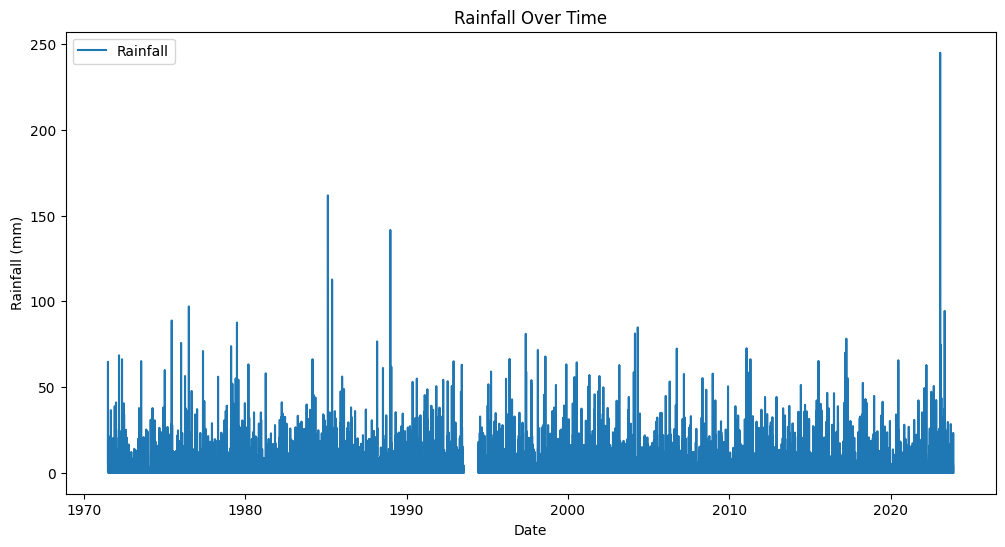

In [9]:
# Data Visualization
import matplotlib.pyplot as plt

# Time series plot of rainfall
plt.figure(figsize=(12, 6))
plt.plot(niwaDf['Date'], niwaDf['Rain (mm)'], label='Rainfall')
plt.xlabel('Date')
plt.ylabel('Rainfall (mm)')
plt.title('Rainfall Over Time')
plt.legend()
plt.show()

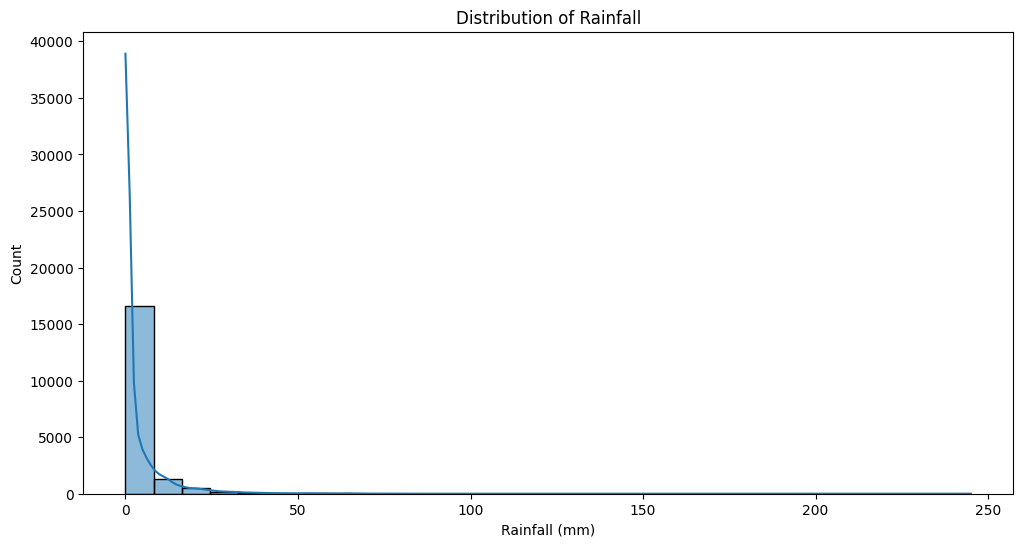

In [10]:
# Histograms
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.histplot(data=niwaDf, x='Rain (mm)', bins=30, kde=True)
plt.xlabel('Rainfall (mm)')
plt.title('Distribution of Rainfall')
plt.show()

In [11]:
niwaDf.columns

Index(['Date', 'Wdir (Deg)', 'WSpd (m/s)', 'GustDir (Deg)', 'GustSpd (m/s)',
       'Tdry (C)', 'Twet (C)', 'RH (%)', 'Tmax (C)', 'Tmin (C)', 'Tgmin (C)',
       'ET10 (C)', 'Pmsl (hPa)', 'Rad (MJ/m2)', 'Rain (mm)'],
      dtype='object')

In [12]:

# Create lag features for prevous 7 days of rainfall and temperature
    
lag_days = 7
for i in range(1, lag_days + 1):
    for column in ['Rain (mm)','Tmax (C)','WSpd (m/s)','GustSpd (m/s)','Twet (C)', 'RH (%)', 'Tgmin (C)']:
        niwaDf[f'lag_{column}_{i}'] = niwaDf[column].shift(i)

# Drop rows with NaN values due to lag features
niwaDf.dropna(inplace=True)

niwaDf.head(5)

,Date,Wdir (Deg),WSpd (m/s),GustDir (Deg),GustSpd (m/s),Tdry (C),Twet (C),RH (%),Tmax (C),Tmin (C),...,lag_Twet (C)_6,lag_RH (%)_6,lag_Tgmin (C)_6,lag_Rain (mm)_7,lag_Tmax (C)_7,lag_WSpd (m/s)_7,lag_GustSpd (m/s)_7,lag_Twet (C)_7,lag_RH (%)_7,lag_Tgmin (C)_7
Date,,,,,,,,,,,,,,,,,,,,,
1971-07-08,1971-07-08,0.0,0.0,140.0,6.2,6.0,5.3,89.3,12.6,3.5,...,12.4,82.1,10.2,1.4,16.6,0.0,9.8,7.5,100.0,1.5
1971-07-09,1971-07-09,130.0,6.2,110.0,8.8,8.0,6.4,77.7,11.6,5.7,...,8.4,88.0,4.0,64.7,14.4,13.4,23.7,12.4,82.1,10.2
1971-07-10,1971-07-10,150.0,3.6,140.0,8.2,7.3,6.0,81.3,12.4,6.2,...,8.3,82.9,6.7,6.1,14.0,4.6,7.7,8.4,88.0,4.0
1971-07-11,1971-07-11,150.0,5.7,110.0,11.8,7.5,6.8,89.9,13.8,6.6,...,10.8,86.7,4.6,5.4,14.1,3.1,10.3,8.3,82.9,6.7
1971-07-12,1971-07-12,220.0,1.5,160.0,7.2,8.3,6.9,80.7,13.4,7.0,...,8.9,88.2,2.1,1.2,14.7,5.1,18.5,10.8,86.7,4.6


In [13]:
print(niwaDf.columns)


Index(['Date', 'Wdir (Deg)', 'WSpd (m/s)', 'GustDir (Deg)', 'GustSpd (m/s)',
       'Tdry (C)', 'Twet (C)', 'RH (%)', 'Tmax (C)', 'Tmin (C)', 'Tgmin (C)',
       'ET10 (C)', 'Pmsl (hPa)', 'Rad (MJ/m2)', 'Rain (mm)', 'lag_Rain (mm)_1',
       'lag_Tmax (C)_1', 'lag_WSpd (m/s)_1', 'lag_GustSpd (m/s)_1',
       'lag_Twet (C)_1', 'lag_RH (%)_1', 'lag_Tgmin (C)_1', 'lag_Rain (mm)_2',
       'lag_Tmax (C)_2', 'lag_WSpd (m/s)_2', 'lag_GustSpd (m/s)_2',
       'lag_Twet (C)_2', 'lag_RH (%)_2', 'lag_Tgmin (C)_2', 'lag_Rain (mm)_3',
       'lag_Tmax (C)_3', 'lag_WSpd (m/s)_3', 'lag_GustSpd (m/s)_3',
       'lag_Twet (C)_3', 'lag_RH (%)_3', 'lag_Tgmin (C)_3', 'lag_Rain (mm)_4',
       'lag_Tmax (C)_4', 'lag_WSpd (m/s)_4', 'lag_GustSpd (m/s)_4',
       'lag_Twet (C)_4', 'lag_RH (%)_4', 'lag_Tgmin (C)_4', 'lag_Rain (mm)_5',
       'lag_Tmax (C)_5', 'lag_WSpd (m/s)_5', 'lag_GustSpd (m/s)_5',
       'lag_Twet (C)_5', 'lag_RH (%)_5', 'lag_Tgmin (C)_5', 'lag_Rain (mm)_6',
       'lag_Tmax (C)_6', 'lag_

# LSTM

Feature selection

In [37]:
# Select lag features for the specified columns
lag_columns = ['Wdir (Deg)', 'WSpd (m/s)', 'GustDir (Deg)', 'GustSpd (m/s)',
       'Tdry (C)', 'Twet (C)', 'RH (%)', 'Tmax (C)', 'Tmin (C)', 'Tgmin (C)',
       'ET10 (C)', 'Pmsl (hPa)', 'Rad (MJ/m2)','lag_Rain (mm)_1',
       'lag_Tmax (C)_1', 'lag_WSpd (m/s)_1', 'lag_GustSpd (m/s)_1',
       'lag_Twet (C)_1', 'lag_RH (%)_1', 'lag_Tgmin (C)_1', 'lag_Rain (mm)_2',
       'lag_Tmax (C)_2', 'lag_WSpd (m/s)_2', 'lag_GustSpd (m/s)_2',
       'lag_Twet (C)_2', 'lag_RH (%)_2', 'lag_Tgmin (C)_2', 'lag_Rain (mm)_3',
       'lag_Tmax (C)_3', 'lag_WSpd (m/s)_3', 'lag_GustSpd (m/s)_3',
       'lag_Twet (C)_3', 'lag_RH (%)_3', 'lag_Tgmin (C)_3', 'lag_Rain (mm)_4',
       'lag_Tmax (C)_4', 'lag_WSpd (m/s)_4', 'lag_GustSpd (m/s)_4',
       'lag_Twet (C)_4', 'lag_RH (%)_4', 'lag_Tgmin (C)_4', 'lag_Rain (mm)_5',
       'lag_Tmax (C)_5', 'lag_WSpd (m/s)_5', 'lag_GustSpd (m/s)_5',
       'lag_Twet (C)_5', 'lag_RH (%)_5', 'lag_Tgmin (C)_5', 'lag_Rain (mm)_6',
       'lag_Tmax (C)_6', 'lag_WSpd (m/s)_6', 'lag_GustSpd (m/s)_6',
       'lag_Twet (C)_6', 'lag_RH (%)_6', 'lag_Tgmin (C)_6', 'lag_Rain (mm)_7',
       'lag_Tmax (C)_7', 'lag_WSpd (m/s)_7', 'lag_GustSpd (m/s)_7',
       'lag_Twet (C)_7', 'lag_RH (%)_7', 'lag_Tgmin (C)_7' ]

# Reshape the data for LSTM
sequence_length = 30

X_sequences = []
y_target = []

for i in range(len(niwaDf) - sequence_length):
    X_sequence = niwaDf.iloc[i:i+sequence_length][lag_columns].values
    X_sequences.append(X_sequence)
    y_target.append(niwaDf.iloc[i + sequence_length]['Rain (mm)'])

X_sequences = np.array(X_sequences)
y_target = np.array(y_target)

In [38]:
# Split Data into Training and Testing Sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_sequences, y_target, test_size=0.2, random_state=42)

In [39]:
# Build the LSTM model
# Fit the StandardScaler to your training data
target_scaler = StandardScaler()

target_scaler.fit(y_train.reshape(-1, 1))

model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(sequence_length, X_train.shape[2])))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

In [40]:
# Train the LSTM Model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1, validation_data=(X_test, y_test))

Epoch 1/50
418/418 [==============================] - 7s 12ms/step - loss: 4266.7197 - val_loss: 274.5379
Epoch 2/50
418/418 [==============================] - 5s 12ms/step - loss: 233.3824 - val_loss: 158.7382
Epoch 3/50
418/418 [==============================] - 5s 12ms/step - loss: 139.0755 - val_loss: 101.7679
Epoch 4/50
418/418 [==============================] - 5s 11ms/step - loss: 99.3617 - val_loss: 81.5523
Epoch 5/50
418/418 [==============================] - 5s 12ms/step - loss: 83.6983 - val_loss: 71.4962
Epoch 6/50
418/418 [==============================] - 5s 12ms/step - loss: 76.1645 - val_loss: 64.6652
Epoch 7/50
418/418 [==============================] - 5s 11ms/step - loss: 71.3995 - val_loss: 59.7203
Epoch 8/50
418/418 [==============================] - 5s 11ms/step - loss: 67.7186 - val_loss: 56.7174
Epoch 9/50
418/418 [==============================] - 5s 12ms/step - loss: 65.5510 - val_loss: 54.6404
Epoch 10/50
418/418 [==============================] - 5s 11ms/ste

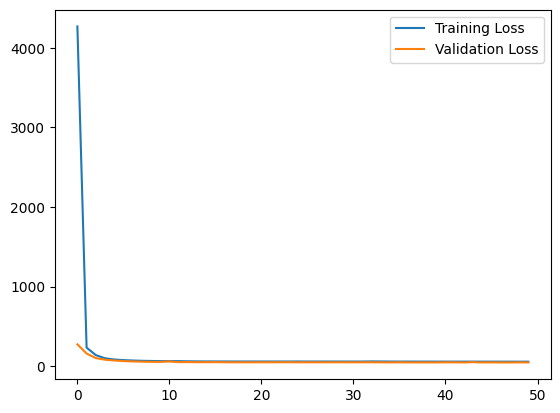

In [41]:
# Plot training loss and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

In [42]:
# Make Predictions
y_pred_scaled = model.predict(X_test)

105/105 [==============================] - 1s 5ms/step


In [43]:
# Inverse transform the predictions for the target variable
from sklearn.metrics import r2_score


y_pred_original_scale = target_scaler.inverse_transform(y_pred_scaled)

# Reshape y_test
y_test = y_test.reshape(-1, 1)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred_original_scale))
print("Root Mean Squared Error (RMSE):", rmse)

# Calculate MAE
mae = np.mean(np.abs(y_test - y_pred_original_scale))
print("Mean Absolute Error (MAE):", mae)

# Calculate MSE
mse = mean_squared_error(y_test, y_pred_original_scale)
print("Mean Squared Error (MSE):", mse)

# Calculate R2 Score
r2 = r2_score(y_test, y_pred_original_scale)
print("R2 Score:", r2)

# Combine the 'date' column with the predictions
y_pred_original_scale = pd.DataFrame({'date': niwaDf.iloc[-len(y_test):]['Date'].values, 'Rain (mm)': y_pred_original_scale.flatten()})


Root Mean Squared Error (RMSE): 29.019630839266096
Mean Absolute Error (MAE): 25.611938698420865
Mean Squared Error (MSE): 842.1389740472838
R2 Score: -15.984591958662328


In [44]:
# Predict rainfall for tomorrow using the Random Forest model
lstm_predict_tomorrow = model.predict(X_test)
lstm_predict_day_after_tomorrow = model.predict(X_test)
lstm_predict_two_days_after_tomorrow = model.predict(X_test)

# Print the predictions
print(f'LSTM Prediction for tomorrow: {lstm_predict_tomorrow[0]} mm')
print(f'LSTM Prediction for the day after tomorrow: {lstm_predict_day_after_tomorrow[0]} mm')
print(f'LSTM Prediction for two days after tomorrow: {lstm_predict_two_days_after_tomorrow[0]} mm')

105/105 [==============================] - 0s 4ms/step
LSTM Prediction for tomorrow: [3.805608] mm
LSTM Prediction for the day after tomorrow: [3.805608] mm
LSTM Prediction for two days after tomorrow: [3.805608] mm


In [45]:
print(y_pred_scaled.shape)  # Check the shape of y_pred_scaled
print(y_test.shape)  # Check the shape of y_test

(3343, 1)
(3343, 1)


In [46]:
# Calculate monthly median rainfall
monthly_median_rainfall = niwaDf.groupby(niwaDf['Date'].dt.month)['Rain (mm)'].median()

# Calculate the percentage of actual rainfall compared to the monthly median
niwaDf['rainfall_percentage'] = (niwaDf['Rain (mm)'] / monthly_median_rainfall[niwaDf['Date'].dt.month].values) * 100

# Create a function to categorize the weather conditions
def categorize_rainfall_condition(percentage):
    if percentage > 200:
        return "Very wet"
    elif percentage > 110:
        return "Moderately wet"
    elif percentage > 90:
        return "Near normal"
    elif percentage > 50:
        return "Moderately dry"
    else:
        return "Very dry"

# Apply the categorization function to create a new column with the weather condition
niwaDf['weather_condition'] = niwaDf['rainfall_percentage'].apply(categorize_rainfall_condition)

# Print the resulting dataframe with weather conditions
print(niwaDf[['Date', 'Rain (mm)', 'rainfall_percentage', 'weather_condition']])



                 Date  Rain (mm)  rainfall_percentage weather_condition
Date                                                                   
1971-07-08 1971-07-08        0.0                  0.0          Very dry
1971-07-09 1971-07-09        0.0                  0.0          Very dry
1971-07-10 1971-07-10        0.0                  0.0          Very dry
1971-07-11 1971-07-11        0.0                  0.0          Very dry
1971-07-12 1971-07-12        0.0                  0.0          Very dry
...               ...        ...                  ...               ...
2023-11-18 2023-11-18       23.2                  inf          Very wet
2023-11-19 2023-11-19        8.4                  inf          Very wet
2023-11-20 2023-11-20        5.8                  inf          Very wet
2023-11-21 2023-11-21        0.4                  inf          Very wet
2023-11-22 2023-11-22        0.0                  NaN          Very dry

[16741 rows x 4 columns]
